In [2]:
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
dir_flux = 'F:/data/model_data/oaflux/data_v3/daily/turbulence/'
dir_cmc = 'F:/data/sst/cmc/CMC0.2deg/v2/'
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
##where to get the data through opendap, use these directories instead
#dir_cmc = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/CMC/CMC0.1deg/v3/'
#dir_flux = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WHOI_OAFlux/version3/daily/lh_oaflux/'
#the latest ccmp is from www.remss.com but they do not have an opendap server so you can use this instead:
#dir_ccmp='https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/'

#################################################################################
import geopy.distance
from math import sin, pi
from scipy import interpolate

#functions for running storm data
import sys
#sys.path.append('C:/Users/gentemann/Google Drive/d_drive/python/storm_heat_content/subroutines/')
#from storm_masking_routines import interpolate_storm_path
#from storm_masking_routines import get_dist_grid
#from storm_masking_routines import closest_dist
#from storm_masking_routines import calculate_storm_mask


In [12]:
#functions for running storm data
def interpolate_storm_path(dsx):
    import numpy as np
    from scipy import interpolate
    import xarray as xr
    #after calculating the distance from the storm it became clear that the storm data is every 6 hours, no matter 
    #how much it may have moved.  So if the storm moved 300 km in 6 hr, when calculating the distance to the storm
    #there were points on the storm track that showed large distances because of the separation to the 6hrly storm points
    #this subroutine interpolates the storm path onto a higher spatial resolution
    #the new storm dataset is carefully put into an identical format with i2 and j2 as dims to match the old format
    ynew = []
    tnew = []
    xnew = []
    wnew = []
    pnew = []
    bnew = []
    dsx['lon'] = (dsx.lon-180) % 360 - 180 #put -180 to 180
    for istep in range(1,dsx.lon.shape[1]):
        dif_lat = dsx.lat[0,istep]-dsx.lat[0,istep-1]
        dif_lon = dsx.lon[0,istep]-dsx.lon[0,istep-1]
        x,y,t = dsx.lon[0,istep-1:istep+1].values,dsx.lat[0,istep-1:istep+1].values,dsx.time[0,istep-1:istep+1].values
        w,p,b = dsx.wind[0,istep-1:istep+1].values,dsx.pres[0,istep-1:istep+1].values,dsx.basin[0,istep-1:istep+1].values
        x1,y1,t1 = dsx.lon[0,istep-1:istep].values,dsx.lat[0,istep-1:istep].values,dsx.time[0,istep-1:istep].values
        w1,p1,b1 = dsx.wind[0,istep-1:istep].values,dsx.pres[0,istep-1:istep].values,dsx.basin[0,istep-1:istep].values
        if abs(dif_lat)>abs(dif_lon):
            isign = np.sign(dif_lat)
            if abs(dif_lat)>0.75:
                ynew1 = np.arange(y[0], y[-1], isign.data*0.75)
                f = interpolate.interp1d(y, x, assume_sorted=False)
                xnew1 = f(ynew1)
                f = interpolate.interp1d(y, t, assume_sorted=False)
                tnew1 = f(ynew1)
                f = interpolate.interp1d(y, w, assume_sorted=False)
                wnew1 = f(ynew1)
                f = interpolate.interp1d(y, p, assume_sorted=False)
                pnew1 = f(ynew1)
                f = interpolate.interp1d(y, b, assume_sorted=False)
                bnew1 = f(ynew1)
            else:
                xnew1,ynew1,tnew1,wnew1,pnew1,bnew1 = x1,y1,t1,w1,p1,b1
            xnew,ynew,tnew = np.append(xnew,xnew1),np.append(ynew,ynew1),np.append(tnew,tnew1) 
            wnew,pnew,bnew = np.append(wnew,wnew1),np.append(pnew,pnew1),np.append(bnew,bnew1) 
        else:
            isign = np.sign(dif_lon)
            if abs(dif_lon)>0.75:
                iwrap_interp = 1
                if (x[0]<-90) & (x[-1]>90):
                    iwrap_interp = -1
                    x[0]=x[0]+360
                if (x[0]>90) & (x[-1]<-90):
                    iwrap_interp = -1
                    x[-1]=x[-1]+360
                xnew1 = np.arange(x[0], x[-1], iwrap_interp*isign.data*0.75)
                f = interpolate.interp1d(x, y, assume_sorted=False)
                ynew1 = f(xnew1)
                f = interpolate.interp1d(x, t, assume_sorted=False)
                tnew1 = f(xnew1)
                f = interpolate.interp1d(x, w, assume_sorted=False)
                wnew1 = f(xnew1)
                f = interpolate.interp1d(x, p, assume_sorted=False)
                pnew1 = f(xnew1)
                f = interpolate.interp1d(x, b, assume_sorted=False)
                bnew1 = f(xnew1)
                xnew1 = (xnew1 - 180) % 360 - 180 #put -180 to 180
            else:
                xnew1,ynew1,tnew1 = x1,y1,t1
                wnew1,pnew1,bnew1 = w1,p1,b1
            xnew,ynew,tnew = np.append(xnew,xnew1),np.append(ynew,ynew1),np.append(tnew,tnew1) 
            wnew,pnew,bnew = np.append(wnew,wnew1),np.append(pnew,pnew1),np.append(bnew,bnew1) 
#remove any repeated points
    ilen=xnew.size
    outputx,outputy,outputt,outputw,outputp,outputb=[],[],[],[],[],[]
    for i in range(ilen-1):
        if (xnew[i]==xnew[i+1]) and (ynew[i]==ynew[i+1]):
            continue
        else:
            outputx,outputy,outputt = np.append(outputx,xnew[i]),np.append(outputy,ynew[i]),np.append(outputt,tnew[i])
            outputw,outputp,outputb = np.append(outputw,wnew[i]),np.append(outputp,pnew[i]),np.append(outputb,bnew[i])
    xnew,ynew,tnew=outputx,outputy,outputt
    wnew,pnew,bnew=outputw,outputp,outputb
#put into xarray
    i2,j2=xnew.shape[0],1
    tem = np.expand_dims(xnew, axis=0)
    xx = xr.DataArray(tem.T,dims=['i2','j2'])
    tem = np.expand_dims(ynew, axis=0)
    yy = xr.DataArray(tem.T,dims=['i2','j2'])
    tem = np.expand_dims(tnew, axis=0)
    tt = xr.DataArray(tem.T,dims=['i2','j2'])
    tem = np.expand_dims(wnew, axis=0)
    ww = xr.DataArray(tem.T,dims=['i2','j2'])
    tem = np.expand_dims(pnew, axis=0)
    pp = xr.DataArray(tem.T,dims=['i2','j2'])
    tem = np.expand_dims(bnew, axis=0)
    bb = xr.DataArray(tem.T,dims=['i2','j2'])
    dsx_new = xr.Dataset({'lon':xx.T,'lat':yy.T,'time':tt.T,'wind':ww.T,'pres':pp.T,'basin':bb.T})
    return dsx_new


In [ ]:
input_year = 2003
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
isave_mld_year = 0 #init MLD monthly data read flag
for root, dirs, files in os.walk(dir_storm_info, topdown=False):
    if root[len(dir_storm_info):len(dir_storm_info)+1]=='.':
        continue
    for name in files:
        if not name.endswith('.nc'):
            continue
        filename=os.path.join(root, name)
        print(filename[36:39],filename[31:35])
        inum_storm=int(filename[36:39])
        iyr_storm=int(filename[31:35])

#        if iyr_storm!=input_year:
#            continue

#        if iyr_storm!=2007: # or iyr_storm<2003:
#            continue
        print(name,filename)
        ds_storm_info = xr.open_dataset(filename)
        ds_storm_info.close()

        ds_storm_interp = interpolate_storm_path(ds_storm_info)
        
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
        ds_storm_interp.to_netcdf(filename)
        print('out:',filename)
    




001 2002
001annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2002\001annual_storm_info_extended.nc
out: f:/data/tc_wakes/database/sst/2002/001_interpolated_track.nc
002 2002
002annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2002\002annual_storm_info_extended.nc
out: f:/data/tc_wakes/database/sst/2002/002_interpolated_track.nc
005 2002
005annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2002\005annual_storm_info_extended.nc
out: f:/data/tc_wakes/database/sst/2002/005_interpolated_track.nc
007 2002
007annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2002\007annual_storm_info_extended.nc
out: f:/data/tc_wakes/database/sst/2002/007_interpolated_track.nc
009 2002
009annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2002\009annual_storm_info_extended.nc
out: f:/data/tc_wakes/database/sst/2002/009_interpolated_track.nc
010 2002
010annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2002\010annual_storm_info_extended.nc
out:

out: f:/data/tc_wakes/database/sst/2002/061_interpolated_track.nc
063 2002
063annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2002\063annual_storm_info_extended.nc
out: f:/data/tc_wakes/database/sst/2002/063_interpolated_track.nc
064 2002
064annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2002\064annual_storm_info_extended.nc
out: f:/data/tc_wakes/database/sst/2002/064_interpolated_track.nc
066 2002
066annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2002\066annual_storm_info_extended.nc
out: f:/data/tc_wakes/database/sst/2002/066_interpolated_track.nc
067 2002
067annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2002\067annual_storm_info_extended.nc
out: f:/data/tc_wakes/database/sst/2002/067_interpolated_track.nc
068 2002
068annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2002\068annual_storm_info_extended.nc
out: f:/data/tc_wakes/database/sst/2002/068_interpolated_track.nc
069 2002
069annual_storm_info_extended.nc f:/data

out: f:/data/tc_wakes/database/sst/2003/040_interpolated_track.nc
042 2003
042annual_storm_info_extended.nc f:/data/tc_wakes/database/info/2003\042annual_storm_info_extended.nc


In [25]:
filename = 'F:/data/tc_wakes/database/info/2004/003annual_storm_info_extended.nc'
ds_storm_info = xr.open_dataset(filename)
ds_storm_info.close()
ds_storm_interp = interpolate_storm_path(ds_storm_info)

Frozen(SortedKeysDict({'j2': 1, 'i2': 72}))
Frozen(SortedKeysDict({'j2': 1, 'i2': 112}))


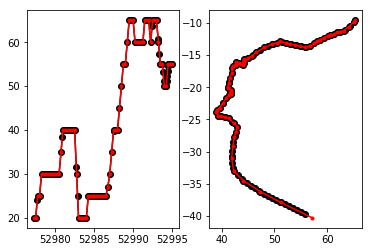

In [29]:
plt.subplot(121)
plt.plot(ds_storm_interp.time[0,:],ds_storm_interp.wind[0,:],'ko-')
plt.plot(ds_storm_info.time[0,:],ds_storm_info.wind[0,:],'r.-')
plt.subplot(122)
plt.plot(ds_storm_interp.lon[0,:],ds_storm_interp.lat[0,:],'ko-')
plt.plot(ds_storm_info.lon[0,:],ds_storm_info.lat[0,:],'r.-')
print(ds_storm_info.dims)
print(ds_storm_interp.dims)

In [45]:
for i in range(0,112):
    print(ds_storm_info.lon[0,i].values,ds_storm_interp.lon[0,i].values)

65.19999854266644 65.19999854266644
64.99999854713678 64.99999854713678
64.09999856725335 64.24999854713678
63.09999858960509 64.09999856725335
62.39999860525131 63.34999856725335
61.89999861642718 63.09999858960509
61.29999862983823 62.39999860525131
60.7999986410141 61.89999861642718
60.49999864771962 61.29999862983823
60.09999865666032 60.7999986410141
59.39999867230654 60.49999864771962
58.69999868795276 60.09999865666032
57.999998703598976 59.39999867230654
57.49999871477485 58.69999868795276
56.799998730421066 57.999998703598976
55.69999875500798 57.49999871477485
54.79999877512455 56.799998730421066
53.79999879747629 56.049998730421066
52.999998815357685 55.69999875500798
52.09999883547425 54.94999875500798
51.099998857825994 54.79999877512455
50.49999887123704 54.04999877512455
49.59999889135361 53.79999879747629
48.09999892488122 53.04999879747629
46.59999895840883 52.999998815357685
45.799998976290226 52.249998815357685
44.99999899417162 52.09999883547425
44.29999900981784 51

IndexError: index 72 is out of bounds for axis 1 with size 72